In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import os
import seaborn as sns
import itertools
import csv
from helpers import *
from helper_funcs import *
from plots import *
from implementations import *
from data_preprocessing import *

In [2]:
current_directory = os.getcwd()

data_path = os.path.join(current_directory, 'dataset')
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path, sub_sample=False)

In [3]:
print('The train and test sets include N_train={} and N_test={} data samples and have D={} features.'.format(x_train.shape[0], x_test.shape[0], x_train.shape[1]))

The train and test sets include N_train=328135 and N_test=109379 data samples and have D=321 features.


In [4]:
#Saving the generated arrays in .npy files in order to have faster access to them
np.save('../data/y_train.npy', y_train)
np.save('../data/x_train.npy', x_train)
np.save('../data/x_test.npy', x_test)
np.save('../data/train_ids.npy', train_ids)
np.save('../data/test_ids.npy', test_ids)

In [5]:
#Loading the arrays from the .npy files
x_train = np.load("../data/x_train.npy")
x_test = np.load("../data/x_test.npy")
y_train = np.load("../data/y_train.npy")
train_ids = np.load("../data/train_ids.npy")
test_ids = np.load("../data/test_ids.npy")

In [6]:
# Open the file and read only the header
file_path = os.path.join(data_path, 'x_train.csv')
with open(file_path, mode='r', newline='') as file:
    csv_reader = csv.reader(file)
    feature_names = np.array(next(csv_reader))  # Get the first row (header)
    feature_names = feature_names[-(len(feature_names)-1):]

In [7]:
## Determine the percentage of examples for which have data per feature 
N_per_feature = x_train.shape[0] - np.sum(np.isnan(x_train), axis = 0)
perc_N_per_feature = N_per_feature / x_train.shape[0]

perc_threshold = [0.7, 0.8, 0.90]
for perc in perc_threshold:
    print('Percentage of features for which examples have at least {} % of data (non-missing) = {} %'.format(100*perc, 
                                                                                                 100 * np.round(np.sum(perc_N_per_feature >= perc) / len(perc_N_per_feature),4)))

Percentage of features for which examples have at least 70.0 % of data (non-missing) = 44.86 %
Percentage of features for which examples have at least 80.0 % of data (non-missing) = 44.55 %
Percentage of features for which examples have at least 90.0 % of data (non-missing) = 43.3 %


In [8]:
## Explore the features for which 99 % of examples have (non missing) data
features_to_keep_logical = perc_N_per_feature > 0.90
feature_names[features_to_keep_logical]

array(['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE',
       'SEQNO', '_PSU', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'HLTHPLN1',
       'PERSDOC2', 'MEDCOST', 'CHECKUP1', 'BPHIGH4', 'BLOODCHO',
       'CVDSTRK3', 'ASTHMA3', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1',
       'HAVARTH3', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'SEX', 'MARITAL',
       'EDUCA', 'RENTHOM1', 'VETERAN3', 'EMPLOY1', 'CHILDREN', 'INCOME2',
       'INTERNET', 'WEIGHT2', 'HEIGHT3', 'QLACTLM2', 'USEEQUIP', 'BLIND',
       'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100',
       'USENOW3', 'ALCDAY5', 'FRUITJU1', 'FRUIT1', 'FVBEANS', 'FVGREEN',
       'FVORANG', 'VEGETAB1', 'EXERANY2', 'STRENGTH', 'SEATBELT',
       'FLUSHOT6', 'PNEUVAC3', 'HIVTST6', 'QSTVER', 'QSTLANG', '_STSTR',
       '_STRWT', '_RAWRAKE', '_WT2RAKE', '_DUALUSE', '_LLCPWT', '_RFHLTH',
       '_HCVU651', '_RFHYPE5', '_CHOLCHK', '_LTASTH1', '_CASTHM1',
       '_ASTHMS1', '_DRDXAR1', '_PRACE1', '_MRACE1', '_HISPANC', '_RACE',
       '_

In [9]:
x_train = x_train[:,features_to_keep_logical]
x_test = x_test[:,features_to_keep_logical]
feature_names = feature_names[features_to_keep_logical]

## Clean and preprocess data
1. Select features to keep
2. Fill missing values with mode (categorical) and median (continuous)  
3. Encode (categorical) and standardize (continuous) data

In [11]:
# Select features to keep 
'''
# features_to_keep = [
'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'HLTHPLN1',
'PERSDOC2', 'MEDCOST', 'CHECKUP1',
'CVDSTRK3', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1',
'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 
'SEX', 'MARITAL', 'RENTHOM1', 'VETERAN3', 'EMPLOY1', 'INTERNET', 
'QLACTLM2', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 
'SMOKE100', 
'EXERANY2',
'FLUSHOT6', 'PNEUVAC3', 'HIVTST6', 
'_RFHYPE5', '_CHOLCHK', '_LTASTH1', '_DRDXAR1', 
'_MRACE1', '_HISPANC', '_RACEGR3', 
'_AGE80',
'HTM4', 
'WTKG3', '_BMI5CAT','_RFBMI5', 
'_CHLDCNT', '_EDUCAG', '_INCOMG', 
'_SMOKER3', 
'DROCDY3_', '_RFBING5','_RFDRHV5', 
'FTJUDA1_', 'FRUTDA1_', 'BEANDAY_', 'GRENDAY_','ORNGDAY_', 'VEGEDA1_','_FRUTSUM', '_FRTLT1', '_VEGLT1', 
'_TOTINDA', 'MAXVO2_', 'FC60_', 
'STRFREQ_', '_PACAT1', '_PAINDX1', '_PASTRNG', '_PAREC1', '_PASTAE1', 
'_LMTACT1','_LMTWRK1', '_LMTSCL1', 
'_RFSEAT2', '_RFSEAT3', 
'_AIDTST3']
'''

features_to_keep = []

# features_to_keep = ['_RFHYPE5', '_CHOLCHK', '_SMOKER3', 'CVDSTRK3', '_TOTINDA', '_FRTLT1', '_VEGLT1', '_RFDRHV5', 'HLTHPLN1', 'MENTHLTH', 'SEX', '_AGEG5YR', 'EDUCA']

In [12]:
# Clean and preprocess train and test data sets
x_train, feature_names_clean, continuous_features_idx, categorical_features_idx, binary_features_idx = clean_data(x_train, feature_names, features_to_keep)
x_test, _, _, _, _ = clean_data(x_test, feature_names, features_to_keep)
feature_names = feature_names_clean

In [13]:
categorical_features_idx = np.concatenate([categorical_features_idx, binary_features_idx]).ravel()
categorical_features = feature_names[categorical_features_idx]
continuous_features = feature_names[continuous_features_idx]

In [14]:
# Preprocess train and test data sets
x_train_cat_encoded, feature_cat_map, feature_cat_encoded_map, x_train_cont_stand, feature_cont_map, x_train_cont_mean, x_train_cont_std = preprocess_data(x_train, feature_names, categorical_features_idx, continuous_features_idx)
x_test_cat_encoded, _, _, x_test_cont_stand, _, x_test_cont_mean, x_test_cont_std = preprocess_data(x_test, feature_names, categorical_features_idx, continuous_features_idx)

In [15]:
# Select features 
# selected_cat_features_idx, selected_cont_features_idx = feature_selection(x_train_cat_encoded, x_train_cont_stand)
selected_cat_features_idx = np.arange(x_train_cat_encoded.shape[1])
selected_cont_features_idx = np.arange(x_train_cont_stand.shape[1])

In [16]:
x_train_cat_encoded = x_train_cat_encoded[:,selected_cat_features_idx]
x_test_cat_encoded = x_test_cat_encoded[:,selected_cat_features_idx]
feature_cat_map =  feature_cat_map[selected_cat_features_idx]
feature_cat_encoded_map = feature_cat_encoded_map[selected_cat_features_idx]

x_train_cont_stand = x_train_cont_stand[:,selected_cont_features_idx]
x_test_cont_stand = x_test_cont_stand[:,selected_cont_features_idx]
feature_cont_map = feature_cont_map[selected_cont_features_idx]

In [17]:
if (np.size(x_train_cat_encoded) > 0) & (np.size(x_train_cont_stand) > 0):
    x_train_processed = np.hstack([x_train_cat_encoded, x_train_cont_stand])
    x_test_processed = np.hstack([x_test_cat_encoded, x_test_cont_stand])

    features_mapping = np.hstack([feature_cat_map, feature_cont_map])
    features_encoded_mapping = np.hstack([feature_cat_encoded_map, feature_cont_map])
elif (np.size(x_train_cat_encoded) > 0):
    x_train_processed = np.hstack([x_train_cat_encoded])
    x_test_processed = np.hstack([x_test_cat_encoded])
    features_mapping = feature_cat_map
    features_encoded_mapping = feature_cat_encoded_map
elif (np.size(x_train_cont_stand) > 0):
    x_train_processed = np.hstack([x_train_cont_stand])
    x_test_processed = np.hstack([x_test_cont_stand])
    features_mapping = feature_cont_map

y_train_processed = np.where(y_train == 1, 1,0).reshape(-1,1)

In [18]:
print('The continuous features kept by feature selection are')
[item for item in continuous_features[feature_cont_map]]

The continuous features kept by feature selection are


['PHYSHLTH',
 'MENTHLTH',
 '_AGE80',
 'HTM4',
 'WTKG3',
 'DROCDY3_',
 'FTJUDA1_',
 'FRUTDA1_',
 'BEANDAY_',
 'GRENDAY_',
 'ORNGDAY_',
 'VEGEDA1_',
 '_FRUTSUM',
 'MAXVO2_',
 'FC60_',
 'STRFREQ_']

In [19]:
print('The categorical features kept by feature selection are')
[item for item in categorical_features[np.unique(feature_cat_map.astype(int))]]

The categorical features kept by feature selection are


['GENHLTH',
 'PERSDOC2',
 'CHECKUP1',
 'DIABETE3',
 'MARITAL',
 'RENTHOM1',
 'EMPLOY1',
 '_MRACE1',
 '_RACEGR3',
 '_CHLDCNT',
 '_EDUCAG',
 '_INCOMG',
 '_SMOKER3',
 '_PACAT1',
 '_PAREC1',
 '_LMTSCL1',
 'HLTHPLN1',
 'MEDCOST',
 'CVDSTRK3',
 'CHCSCNCR',
 'CHCOCNCR',
 'CHCCOPD1',
 'ADDEPEV2',
 'CHCKIDNY',
 'SEX',
 'VETERAN3',
 'INTERNET',
 'QLACTLM2',
 'USEEQUIP',
 'BLIND',
 'DECIDE',
 'DIFFWALK',
 'DIFFDRES',
 'DIFFALON',
 'SMOKE100',
 'EXERANY2',
 'FLUSHOT6',
 'PNEUVAC3',
 'HIVTST6',
 '_RFHYPE5',
 '_CHOLCHK',
 '_LTASTH1',
 '_DRDXAR1',
 '_HISPANC',
 '_BMI5CAT',
 '_RFBMI5',
 '_RFBING5',
 '_RFDRHV5',
 '_FRTLT1',
 '_VEGLT1',
 '_TOTINDA',
 '_PAINDX1',
 '_PASTRNG',
 '_PASTAE1',
 '_LMTACT1',
 '_LMTWRK1',
 '_RFSEAT2',
 '_RFSEAT3',
 '_AIDTST3',
 'HLTHPLN1',
 'MEDCOST',
 'CVDSTRK3',
 'CHCSCNCR',
 'CHCOCNCR',
 'CHCCOPD1',
 'ADDEPEV2',
 'CHCKIDNY',
 'SEX',
 'VETERAN3',
 'INTERNET',
 'QLACTLM2',
 'USEEQUIP',
 'BLIND',
 'DECIDE',
 'DIFFWALK',
 'DIFFDRES',
 'DIFFALON',
 'SMOKE100',
 'EXERANY2',
 'FLUSH

In [20]:
np.save('../data/x_train_processed.npy', x_train_processed)
np.save('../data/x_test_processed.npy', x_test_processed)
np.save('../data/features_mapping.npy', features_mapping)
np.save('../data/features_encoded_mapping.npy', features_encoded_mapping)
np.save('../data/y_train_processed.npy', y_train_processed)
np.save('../data/categorical_features.npy', categorical_features)
np.save('../data/continuous_features.npy', continuous_features)

In [21]:
x_train_processed = np.load("../data/x_train_processed.npy")
x_test_processed = np.load("../data/x_test_processed.npy")
features_mapping = np.load("../data/features_mapping.npy")
features_encoded_mapping = np.load("../data/features_encoded_mapping.npy")
y_train_processed = np.load('../data/y_train_processed.npy')
categorical_features = np.load("../data/categorical_features.npy")
continuous_features = np.load("../data/continuous_features.npy")

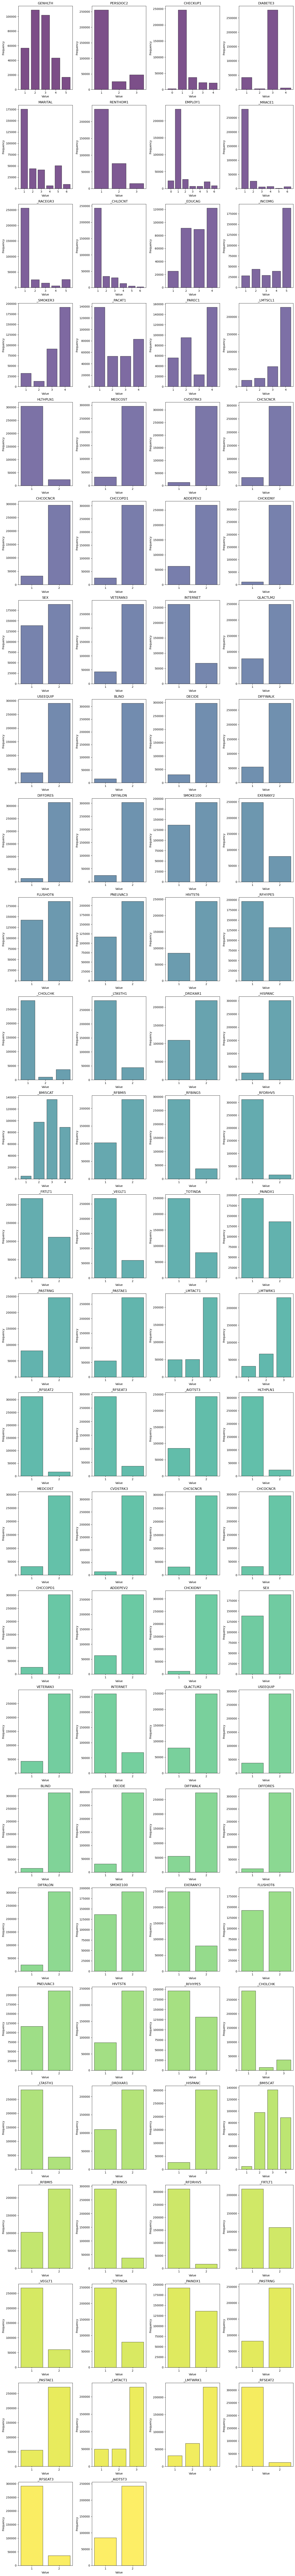

In [22]:
# Visualization of categorical features
data = x_train[:, categorical_features_idx]
data_list = [data[:, col] for col in range(len(categorical_features_idx))]
features_list = categorical_features
plot_histograms(data_list, features_list, num_cols=4)

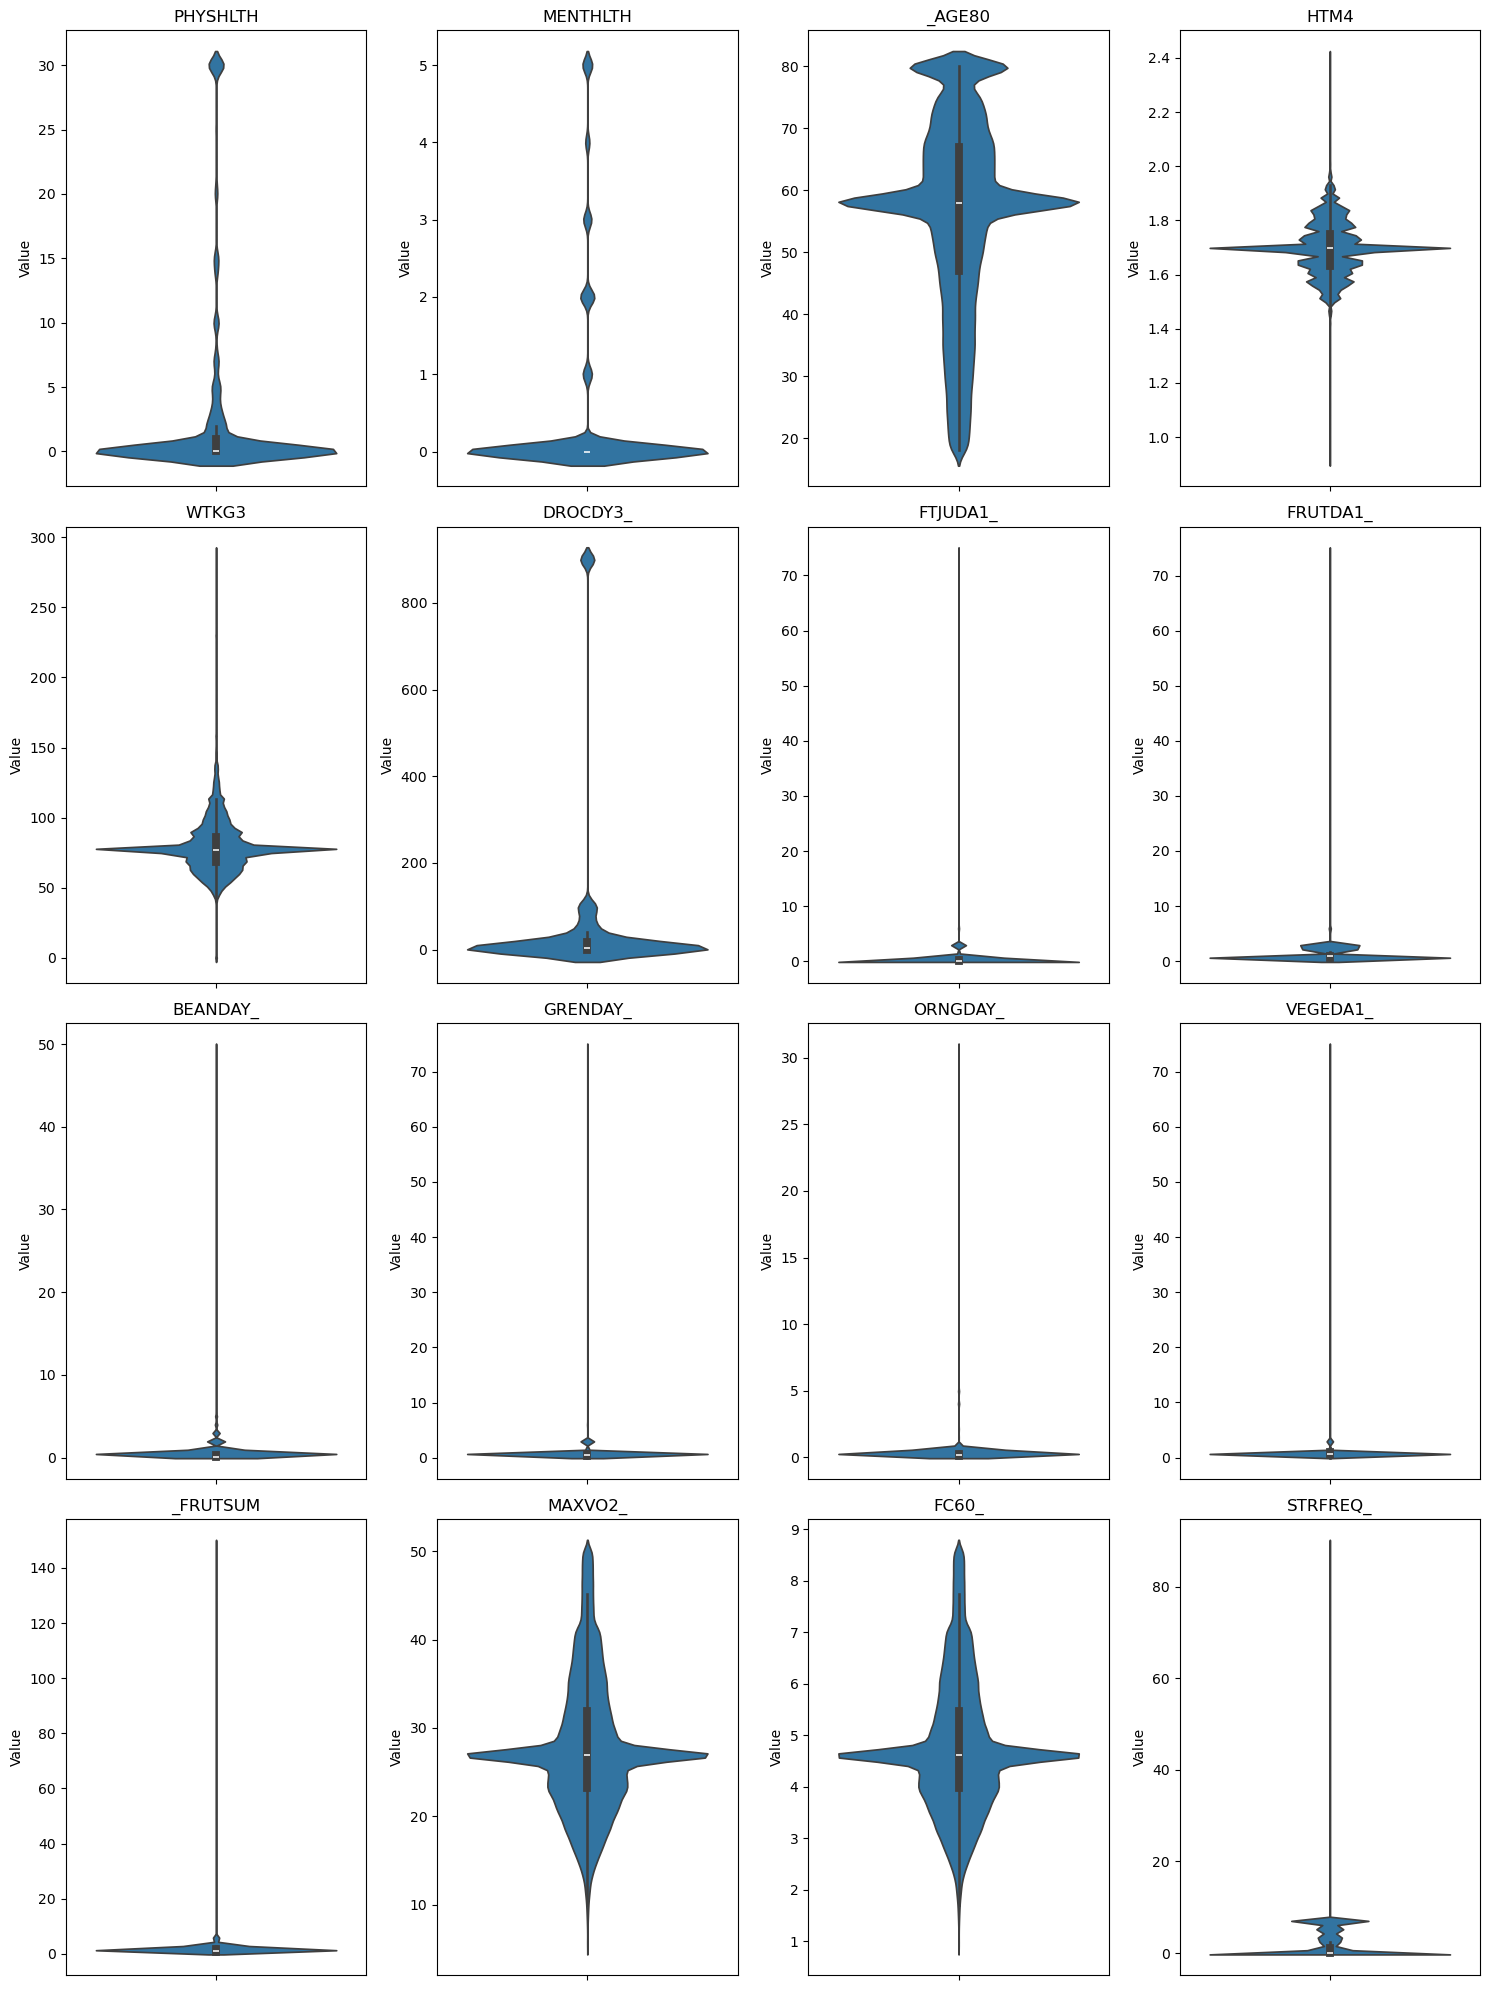

In [23]:
# Visualization of categorical features
data = x_train[:,continuous_features_idx]
data_list = [data[:, col] for col in range(len(continuous_features_idx))]
features_list = continuous_features
plot_boxplots(data_list, features_list, num_cols=4)

## Build model data
1. Add offset
2. Split train data into training and validation sets
3. Balance data 

In [25]:
# Add offset term
y_train, tx_train = build_model_data(y_train_processed, x_train_processed)
tx_test = np.c_[np.ones(x_test_processed.shape[0]), x_test_processed]

In [26]:
# Split data into train and validation sets
split_ratio = 0.7
split_index = int(len(tx_train) * split_ratio)

# Create a random permutation of indices
np.random.seed(20)
indices = np.random.permutation(len(tx_train))

# Split the indices for training and validation sets
train_indices = indices[:split_index]
validation_indices = indices[split_index:]

# Use the indices to split the data
tx_train_training = tx_train[train_indices]
tx_train_validation = tx_train[validation_indices]
y_train_training = y_train[train_indices]
y_train_validation = y_train[validation_indices]

In [27]:
# Balance data: oversample minority class
y_majority = y_train_training[y_train_training == 0]
y_minority = y_train_training[y_train_training == 1]
X_majority = tx_train_training[y_train_training.flatten() == 0,:]
X_minority = tx_train_training[y_train_training.flatten() == 1,:]

oversample_size = len(y_majority)
indices = np.random.choice(len(X_minority), oversample_size, replace=True)
X_minority_oversampled = X_minority[indices]
y_minority_oversampled = y_minority[indices]

tx_training_balanced = np.vstack((X_minority_oversampled, X_majority)) # Combine oversampled minority class with majority class
y_training_balanced = np.hstack((y_minority_oversampled, y_majority)).reshape((-1,1))

## Model selection and validation

The selected models are
- Gradient Descent with MSE loss function
- Stochastic Gradient Descent with MAE loss function
- Least squares 
- Regularized least squares
- Logistic regression
- Ridge logistic regression

they are evaluated on the metrics
- loss
- accuracy
- F1-score
- MSE
- R squared

and they are optimized over
- the learning rate - _iterative algorithms (GD, SGD)_
- the penalty - _regularized algorithms (ridge regression)_
- the training / validation split ratio 

##### Initialisation of the algorithm

In [30]:
# Define the parameters of the algorithms
max_iters = 100
learning_rate = np.linspace(0.01, 0.1, 10)
penalty = np.linspace(0.01, 10, 10)

# Initialization
w_initial = np.zeros((tx_training_balanced.shape[1],1))

#### Gradient Descent - MSE loss function

In [32]:
"""Gradient descent, mse loss function"""
# Iterate over learning rate parameter values 
gd_mse_loss_min = np.zeros(len(learning_rate))
gd_mse_accuracy = np.zeros(len(learning_rate))
gd_mse_f1_score = np.zeros(len(learning_rate))
gd_mse_rmse = np.zeros(len(learning_rate))
gd_mse_r_squared = np.zeros(len(learning_rate))
gd_mse_ws_var_gamma = []
gd_mse_losses_var_gamma = []

for idx, gamma in enumerate(learning_rate):
    
    # Execute optimization algorithm, save losses and weights at every iteration
    start_time = datetime.datetime.now()
    gd_mse_losses, gd_mse_ws = mean_squared_error_gd(y_training_balanced, tx_training_balanced, w_initial, max_iters, gamma)
    end_time = datetime.datetime.now()
    
    # Print excecution time
    execution_time = (end_time - start_time).total_seconds()
    print("GD - mse: gamma={g:.3f}, execution time={t:.3f} seconds \n".format(g=gamma, t=execution_time))

    # Compute accuracy metrics
    y_pred = tx_train_validation.dot(gd_mse_ws[-1])
    y_pred = np.where(y_pred > 0.5, 1, 0)

    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    accuracy = (tp + tn) /(tp + tn + fp + fn)
    f1_score = 2*tp/(2*tp + fp + fn)
    mse = calculate_mse(y_train_validation - y_pred)
    r2 = r_squared(y_train_validation, y_pred)
    
    # Save losses, weights, accuracy metrics for hyperparameter optimization over learning rate
    gd_mse_loss_min[idx] = gd_mse_losses[-1]
    gd_mse_accuracy[idx] = accuracy
    gd_mse_f1_score[idx] = f1_score
    gd_mse_rmse[idx] = np.sqrt(mse)
    gd_mse_r_squared[idx] = r2

    gd_mse_ws_var_gamma.append(gd_mse_ws[-1])
    gd_mse_losses_var_gamma.append(gd_mse_losses)
    

loss=0.09322065636425411
GD - mse: gamma=0.010, execution time=5.219 seconds 

loss=0.09000400238816887
GD - mse: gamma=0.020, execution time=3.758 seconds 

loss=0.08834568990980309
GD - mse: gamma=0.030, execution time=3.416 seconds 

loss=0.08735012829397289
GD - mse: gamma=0.040, execution time=3.666 seconds 

loss=181696141.40452492
GD - mse: gamma=0.050, execution time=7.263 seconds 

loss=8.64194741570501e+35
GD - mse: gamma=0.060, execution time=7.624 seconds 

loss=6.940343392079444e+56
GD - mse: gamma=0.070, execution time=8.075 seconds 

loss=4.4148117541531445e+73
GD - mse: gamma=0.080, execution time=7.419 seconds 

loss=4.95999663771373e+87
GD - mse: gamma=0.090, execution time=7.456 seconds 

loss=5.880682196019826e+99
GD - mse: gamma=0.100, execution time=7.334 seconds 



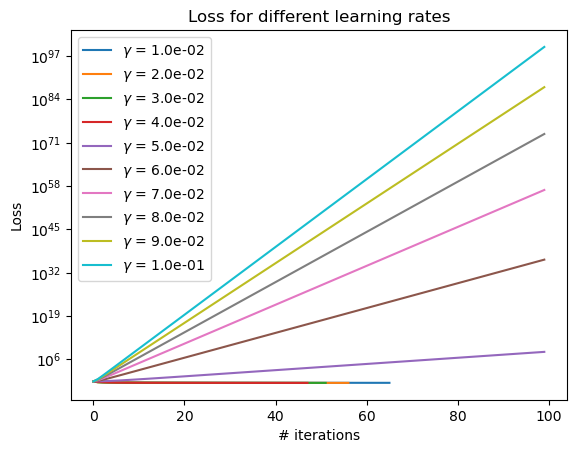

In [33]:
# Visualization
plot_loss_variable_gamma(gd_mse_losses_var_gamma, learning_rate)

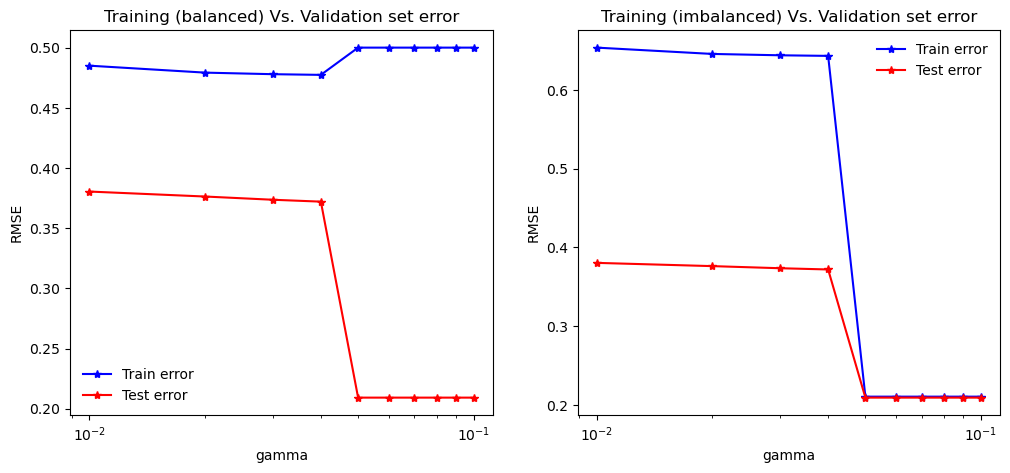

In [34]:
# Training (balanced) Vs. Validation error
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

rmse_validation = gd_mse_rmse
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, gd_mse_ws_var_gamma, learning_rate)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, learning_rate, 'gamma')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, learning_rate, 'gamma')

In [35]:
# Get optimal parameter and corresponding model weights, apply to test set
metrics = np.hstack([gd_mse_loss_min.reshape(-1,1), gd_mse_accuracy.reshape(-1,1), gd_mse_f1_score.reshape(-1,1), gd_mse_rmse.reshape(-1,1), gd_mse_r_squared.reshape(-1,1)])
metric_name = 'f1_score'

hyperparam_optimization(metric_name, metrics, gd_mse_ws_var_gamma, learning_rate, 'gamma', tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test, False)

The optimal parameter is gamma=0.040 given optimization of the metric f1_score evaluating 0.32885.
The optimal weights are w = [[ 3.99467390e-02]
 [-3.06926273e-02]
 [ 1.08460582e-02]
 [ 4.42518067e-02]
 [ 4.10658890e-02]
 [ 2.15141015e-02]
 [-6.00352101e-03]
 [ 4.27246884e-02]
 [-4.98949214e-04]
 [-8.67352587e-04]
 [-1.70460239e-03]
 [-6.01354148e-04]
 [-1.61131418e-02]
 [ 3.03398985e-03]
 [ 1.10933766e-02]
 [ 1.66898075e-02]
 [ 3.47177976e-03]
 [-3.49037253e-03]
 [ 2.72624947e-04]
 [ 1.97756833e-02]
 [ 4.17714562e-03]
 [ 4.42882260e-03]
 [-2.09922933e-03]
 [ 2.70308252e-03]
 [ 1.14590507e-04]
 [-2.55573381e-03]
 [-4.94598559e-04]
 [ 6.10148256e-05]
 [ 2.38009829e-03]
 [-1.58420998e-03]
 [ 1.47075665e-04]
 [ 2.08450136e-03]
 [-5.59636385e-04]
 [ 1.05303918e-03]
 [ 3.08270587e-03]
 [ 7.87107112e-03]
 [-8.03485458e-04]
 [-5.54780157e-03]
 [-1.46688547e-03]
 [-6.75423030e-05]
 [-2.93547988e-04]
 [ 1.31177775e-02]
 [ 1.14136486e-02]
 [-2.41595062e-03]
 [ 1.64108512e-02]
 [ 6.04036431e-03]

#### Stochastic gradient descent - MSE loss function

In [37]:
"""Stochastic gradient descent, mse loss function"""
# Iterate over learning rate parameter values 
learning_rate = np.linspace(0.001, 0.1, 10)

sgd_mse_loss_min = np.zeros(len(learning_rate))
sgd_mse_accuracy = np.zeros(len(learning_rate))
sgd_mse_f1_score = np.zeros(len(learning_rate))
sgd_mse_rmse = np.zeros(len(learning_rate))
sgd_mse_r_squared = np.zeros(len(learning_rate))
sgd_mse_ws_var_gamma = []
sgd_mse_losses_var_gamma = []

for idx, gamma in enumerate(learning_rate):
    
    # Execute optimization algorithm, save losses and weights at every iteration
    start_time = datetime.datetime.now()
    losses, ws = mean_squared_error_sgd(y_training_balanced, tx_training_balanced, w_initial, max_iters, gamma)
    end_time = datetime.datetime.now()
    
    # Print excecution time
    execution_time = (end_time - start_time).total_seconds()
    print("GD - mse: gamma={g:.3f}, execution time={t:.3f} seconds \n".format(g=gamma, t=execution_time))

    # Compute accuracy metrics
    y_pred = tx_train_validation.dot(ws[-1])
    y_pred = np.where(y_pred > 0.5, 1, 0)

    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    accuracy = (tp + tn) /(tp + tn + fp + fn)
    f1_score = 2*tp/(2*tp + fp + fn)
    mse = calculate_mse(y_train_validation - y_pred)
    r2 = r_squared(y_train_validation, y_pred)
    
    # Save losses, weights, accuracy metrics for hyperparameter optimization over learning rate
    sgd_mse_loss_min[idx] = losses[-1]
    sgd_mse_accuracy[idx] = accuracy
    sgd_mse_f1_score[idx] = f1_score
    sgd_mse_rmse[idx] = np.sqrt(mse)
    sgd_mse_r_squared[idx] = r2

    sgd_mse_ws_var_gamma.append(ws[-1])
    sgd_mse_losses_var_gamma.append(losses)
    

loss=0.15558881769005736
GD - mse: gamma=0.001, execution time=0.008 seconds 

loss=0.3132746487729759
GD - mse: gamma=0.012, execution time=0.002 seconds 

loss=1.8960719331055935
GD - mse: gamma=0.023, execution time=0.005 seconds 

loss=355.44013601311593
GD - mse: gamma=0.034, execution time=0.002 seconds 

loss=53059746.729281396
GD - mse: gamma=0.045, execution time=0.002 seconds 

loss=6.033583373746586e+32
GD - mse: gamma=0.056, execution time=0.004 seconds 

loss=7.243323057099872e+38
GD - mse: gamma=0.067, execution time=0.005 seconds 

loss=5.319571302812912e+64
GD - mse: gamma=0.078, execution time=0.002 seconds 

loss=2.0624920898692823e+73
GD - mse: gamma=0.089, execution time=0.007 seconds 

loss=7.863809406662123e+84
GD - mse: gamma=0.100, execution time=0.001 seconds 



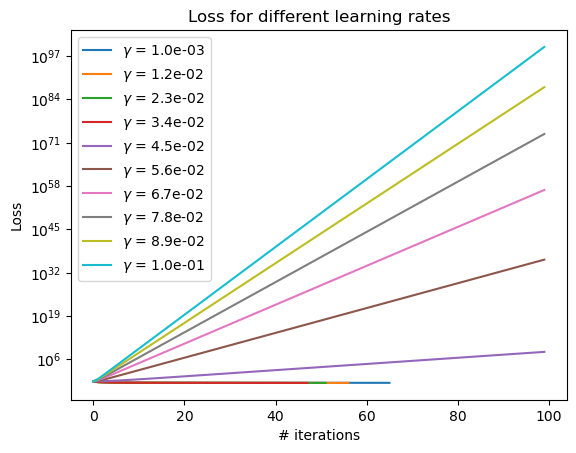

In [38]:
# Visualization
plot_loss_variable_gamma(gd_mse_losses_var_gamma, learning_rate)

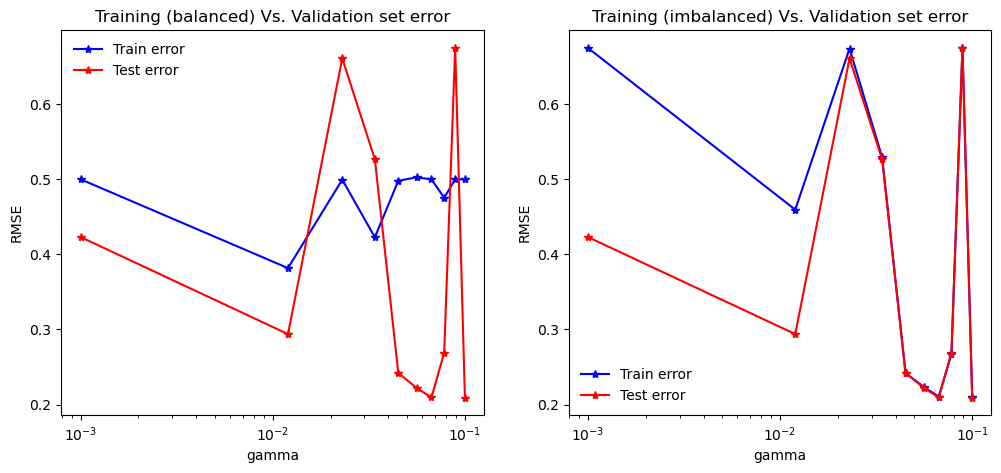

In [39]:
# Training (balanced) Vs. Validation error
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

rmse_validation = sgd_mse_rmse
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, sgd_mse_ws_var_gamma, learning_rate)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, learning_rate, 'gamma')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, learning_rate, 'gamma')

In [40]:
# Get optimal parameter and corresponding model weights, apply to test set
metrics = np.hstack([sgd_mse_loss_min.reshape(-1,1), sgd_mse_accuracy.reshape(-1,1), sgd_mse_f1_score.reshape(-1,1), sgd_mse_rmse.reshape(-1,1), sgd_mse_r_squared.reshape(-1,1)])
metric_name = 'loss'

hyperparam_optimization(metric_name, metrics, sgd_mse_ws_var_gamma, learning_rate, 'gamma', tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test, False)

The optimal parameter is gamma=0.001 given optimization of the metric loss evaluating 0.15559.
The optimal weights are w = [[ 1.44333361e-02]
 [ 3.64161339e-03]
 [ 9.27843865e-04]
 [ 7.06070843e-03]
 [ 4.69675698e-03]
 [ 1.62180662e-03]
 [ 1.59081013e-04]
 [ 1.53365340e-02]
 [-1.56843742e-03]
 [ 6.33563733e-04]
 [ 3.16757846e-05]
 [ 0.00000000e+00]
 [ 8.09612859e-03]
 [-1.76532206e-04]
 [ 3.44143659e-03]
 [ 7.32704938e-03]
 [ 5.21805632e-05]
 [-3.23978075e-03]
 [ 2.16131688e-03]
 [ 6.84022137e-03]
 [ 6.02229640e-04]
 [ 8.58439377e-03]
 [ 1.41123266e-03]
 [ 1.58943028e-03]
 [-7.56636266e-04]
 [-4.74440697e-04]
 [-6.72631405e-04]
 [ 1.07038462e-03]
 [ 0.00000000e+00]
 [ 1.09392793e-03]
 [ 0.00000000e+00]
 [ 7.81591767e-04]
 [ 1.07038462e-03]
 [ 1.87551970e-03]
 [-4.85319972e-04]
 [-2.60951822e-04]
 [-1.54122354e-03]
 [-1.83688318e-04]
 [ 1.92836265e-04]
 [-6.32057144e-04]
 [-8.07984838e-04]
 [ 4.76373901e-03]
 [ 6.02013654e-03]
 [-9.30665475e-04]
 [-2.16535708e-05]
 [ 2.07045458e-03]
 [ 

#### Least squares

In [42]:
"""Least squares"""

# Execute optimization algorithm, save loss and w
start_time = datetime.datetime.now()
ls_loss, ls_w = least_squares(y_training_balanced, tx_training_balanced)
end_time = datetime.datetime.now()

# Print execution time 
execution_time = (end_time - start_time).total_seconds()
print("Least squares: execution time={t:.3f} seconds".format(t=execution_time))

# Compute accuracy metrics
y_pred = tx_train_validation.dot(ls_w)
y_pred = np.where(y_pred > 0.5, 1, 0)

tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
accuracy = (tp + tn) /(tp + tn + fp + fn)
f1_score = 2*tp/(2*tp + fp + fn)
mse = calculate_mse(y_train_validation - y_pred)
r2 = r_squared(y_train_validation, y_pred)

print_report(ls_w, False, tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test)

print('f1-score {}'.format(f1_score))

LinAlgError: Singular matrix

#### Ridge regression

In [43]:
"""Ridge regression"""

# Iterate over penalty parameter values 
ridge_ls_loss = np.zeros(len(penalty))
ridge_ls_accuracy = np.zeros(len(penalty))
ridge_ls_f1_score = np.zeros(len(penalty))
ridge_ls_rmse = np.zeros(len(penalty))
ridge_ls_r_squared = np.zeros(len(penalty))
ridge_ls_ws_var_lambda = []

for idx, lambda_ in enumerate(penalty):

    # Execute optimization algorithm, save w 
    start_time = datetime.datetime.now()
    ridge_ls_losses, ridge_ls_ws = ridge_regression(y_training_balanced, tx_training_balanced, lambda_)
    end_time = datetime.datetime.now()

    # Print execution time 
    execution_time = (end_time - start_time).total_seconds()
    print("Ridge regression: lambda={l:.3f}, execution time={t:.3f} seconds \n".format(l=lambda_, t=execution_time))

    # Compute accuracy metrics
    y_pred = tx_train_validation.dot(ridge_ls_ws)
    y_pred = np.where(y_pred > 0.5, 1, 0)

    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    accuracy = (tp + tn) /(tp + tn + fp + fn)
    f1_score = 2*tp/(2*tp + fp + fn)
    mse = calculate_mse(y_train_validation - y_pred)
    r2 = r_squared(y_train_validation, y_pred)
    
    # Save losses, weights, accuracy metrics for hyperparameter optimization over learning rate
    ridge_ls_loss[idx] = ridge_ls_losses
    ridge_ls_accuracy[idx] = accuracy
    ridge_ls_f1_score[idx] = f1_score
    ridge_ls_rmse[idx] = np.sqrt(mse)
    ridge_ls_r_squared[idx] = r2

    ridge_ls_ws_var_lambda.append(ridge_ls_ws)
    

Ridge regression: lambda=0.010, execution time=0.520 seconds 

Ridge regression: lambda=1.120, execution time=0.591 seconds 

Ridge regression: lambda=2.230, execution time=0.765 seconds 

Ridge regression: lambda=3.340, execution time=0.566 seconds 

Ridge regression: lambda=4.450, execution time=0.509 seconds 

Ridge regression: lambda=5.560, execution time=0.501 seconds 

Ridge regression: lambda=6.670, execution time=0.565 seconds 

Ridge regression: lambda=7.780, execution time=0.630 seconds 

Ridge regression: lambda=8.890, execution time=0.664 seconds 

Ridge regression: lambda=10.000, execution time=0.653 seconds 



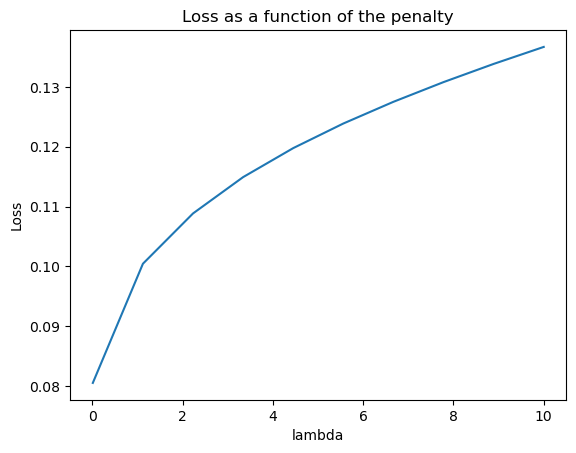

In [44]:
fig = plt.figure()
plt.plot(penalty, ridge_ls_loss)
plt.title("Loss as a function of the penalty")
plt.xlabel("lambda")
plt.ylabel("Loss")
plt.show()

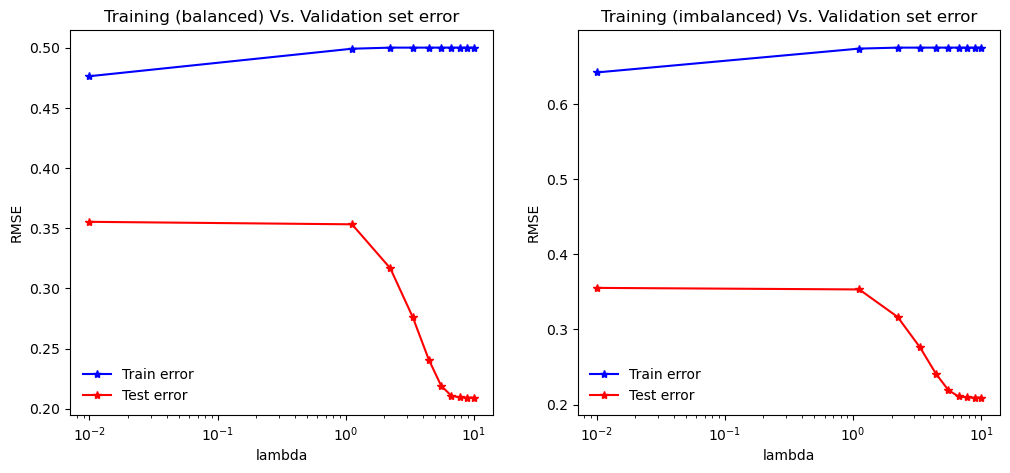

In [45]:
# Training (balanced) Vs. Validation error
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

rmse_validation = ridge_ls_rmse
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, ridge_ls_ws_var_lambda, penalty)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, penalty, 'lambda')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, penalty, 'lambda')

In [46]:
metrics = np.hstack([ridge_ls_loss.reshape(-1,1), ridge_ls_accuracy.reshape(-1,1), ridge_ls_f1_score.reshape(-1,1), ridge_ls_rmse.reshape(-1,1), ridge_ls_r_squared.reshape(-1,1)])
metric_name = 'loss'

hyperparam_optimization(metric_name, metrics, ridge_ls_ws_var_lambda, penalty, 'lambda', tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test, False)

The optimal parameter is lambda=0.010 given optimization of the metric loss evaluating 0.08053.
The optimal weights are w = [[ 1.98956554e-01]
 [-3.69226850e-03]
 [ 8.02194314e-02]
 [ 1.59979758e-01]
 [ 1.82789855e-01]
 [ 5.97837734e-02]
 [-1.30386981e-02]
 [ 7.37498473e-02]
 [ 3.84974049e-02]
 [ 3.19317181e-02]
 [ 3.03241456e-02]
 [-1.27795277e-02]
 [-4.83931007e-02]
 [-7.09082492e-03]
 [ 2.65930061e-04]
 [ 3.17718112e-02]
 [ 1.34719984e-02]
 [-2.69997002e-02]
 [-4.08186011e-03]
 [ 2.31507814e-02]
 [ 2.13353927e-02]
 [-1.09597566e-02]
 [-9.74923991e-03]
 [ 9.10375970e-03]
 [-6.12465813e-03]
 [-7.79397340e-03]
 [ 4.57703674e-03]
 [-1.21570446e-02]
 [ 8.13132914e-03]
 [-2.04837536e-02]
 [-5.40231435e-05]
 [ 1.55180626e-02]
 [-2.34459095e-02]
 [-1.05415443e-02]
 [ 1.22625922e-02]
 [ 1.17795798e-01]
 [-2.00098884e-03]
 [-2.19780536e-02]
 [-6.92400434e-03]
 [ 4.26188379e-03]
 [-2.21231603e-03]
 [ 1.58300860e-02]
 [ 2.15788228e-02]
 [ 1.05645091e-02]
 [ 1.69755331e-02]
 [ 8.72954915e-03]
 [

#### Logistic regression

In [48]:
"""Logistic regression - gradient descent"""
# Iterate over learning rate parameter values 
logistic_gd_loss_min = np.zeros(len(learning_rate))
logistic_gd_accuracy = np.zeros(len(learning_rate))
logistic_gd_f1_score = np.zeros(len(learning_rate))
logistic_gd_rmse = np.zeros(len(learning_rate))
logistic_gd_r_squared = np.zeros(len(learning_rate))
logistic_gd_ws_var_gamma = []
logistic_gd_losses_var_gamma = []

for idx, gamma in enumerate(learning_rate):
    
    # Execute optimization algorithm, save losses and w at every iteration
    start_time = datetime.datetime.now()
    logistic_gd_losses, logistic_gd_ws = logistic_regression(y_training_balanced, tx_training_balanced, w_initial, max_iters, gamma)
    end_time = datetime.datetime.now()
    
    # Print excecution time
    execution_time = (end_time - start_time).total_seconds()
    print("Logistic regression - Gradient descent: gamma={g:.3f}, execution time={t:.3f} seconds \n".format(g=gamma, t=execution_time))

    # Compute accuracy metrics
    y_pred = sigmoid(tx_train_validation.dot(logistic_gd_ws[-1])) 
    y_pred = np.where(y_pred > 0, 1, 0)

    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    accuracy = (tp + tn) /(tp + tn + fp + fn)
    f1_score = 2*tp/(2*tp + fp + fn)
    mse = calculate_mse(y_train_validation - y_pred)
    r2 = r_squared(y_train_validation, y_pred)
    
    # Save losses, weights, accuracy metrics for hyperparameter optimization over learning rate
    logistic_gd_loss_min[idx] = logistic_gd_losses[-1]
    logistic_gd_accuracy[idx] = accuracy
    logistic_gd_f1_score[idx] = f1_score
    logistic_gd_rmse[idx] = np.sqrt(mse)
    logistic_gd_r_squared[idx] = r2

    logistic_gd_ws_var_gamma.append(logistic_gd_ws[-1])
    logistic_gd_losses_var_gamma.append(logistic_gd_losses)

loss=0.6695854581134367
Logistic regression - Gradient descent: gamma=0.001, execution time=8.275 seconds 

loss=0.5635384694837239
Logistic regression - Gradient descent: gamma=0.012, execution time=8.610 seconds 

loss=0.5367669857718146
Logistic regression - Gradient descent: gamma=0.023, execution time=8.196 seconds 

loss=0.525038310676939
Logistic regression - Gradient descent: gamma=0.034, execution time=8.243 seconds 

loss=0.5181336021744611
Logistic regression - Gradient descent: gamma=0.045, execution time=8.448 seconds 

loss=0.5133798192501859
Logistic regression - Gradient descent: gamma=0.056, execution time=7.852 seconds 

loss=0.5098116299191613
Logistic regression - Gradient descent: gamma=0.067, execution time=7.824 seconds 

loss=0.5069918027836138
Logistic regression - Gradient descent: gamma=0.078, execution time=8.499 seconds 

loss=0.5046873285080802
Logistic regression - Gradient descent: gamma=0.089, execution time=8.536 seconds 

loss=0.5027588477257051
Logis

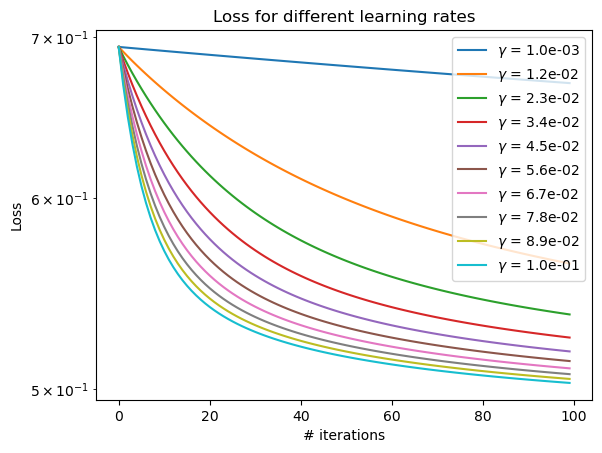

In [49]:
# Visualization
plot_loss_variable_gamma(logistic_gd_losses_var_gamma, learning_rate)

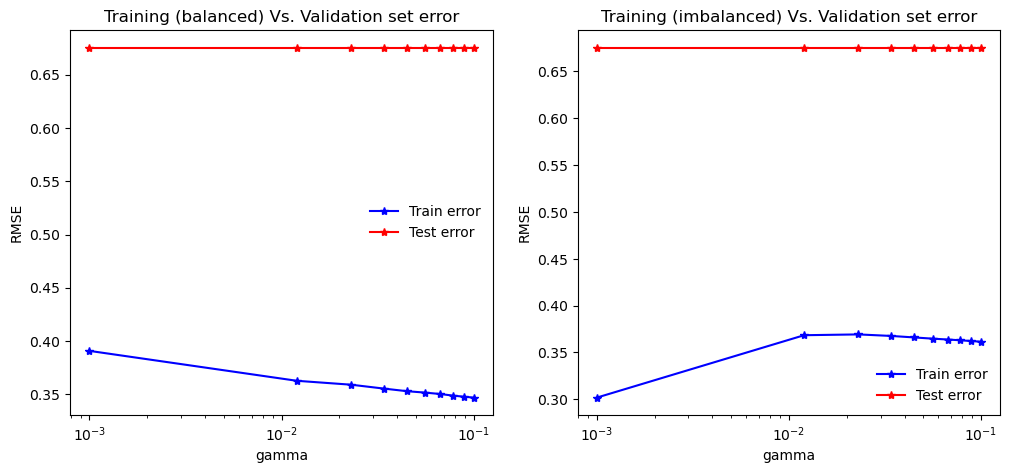

In [50]:
# Training (balanced) Vs. Validation error
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

rmse_validation = logistic_gd_rmse
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, logistic_gd_ws_var_gamma, learning_rate)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, learning_rate, 'gamma')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, learning_rate, 'gamma')

In [51]:
# Get optimal parameter and corresponding model weights, apply to test set
metrics = np.hstack([logistic_gd_loss_min.reshape(-1,1), logistic_gd_accuracy.reshape(-1,1), logistic_gd_f1_score.reshape(-1,1), logistic_gd_rmse.reshape(-1,1), logistic_gd_r_squared.reshape(-1,1)])
metric_name = 'loss'

hyperparam_optimization(metric_name, metrics, logistic_gd_ws_var_gamma, learning_rate, 'gamma', tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test, True)

The optimal parameter is gamma=0.100 given optimization of the metric loss evaluating 0.50276.
The optimal weights are w = [[ 8.06164285e-02]
 [-1.59715319e-01]
 [ 4.33679147e-02]
 [ 1.82251495e-01]
 [ 1.56531332e-01]
 [ 8.94615874e-02]
 [-4.87333416e-02]
 [ 1.32471950e-01]
 [-2.00772548e-02]
 [-1.54238683e-02]
 [-1.61762185e-02]
 [-3.98410514e-03]
 [-1.40150291e-01]
 [ 9.90290145e-03]
 [ 3.03480509e-02]
 [ 6.31485691e-02]
 [ 1.18781154e-02]
 [-4.80566105e-02]
 [-4.22230936e-03]
 [ 4.72415077e-02]
 [ 5.90629524e-03]
 [-1.06376191e-02]
 [-1.23755973e-02]
 [ 8.90701316e-03]
 [-2.43107044e-03]
 [-1.78911433e-02]
 [-1.19820828e-02]
 [-6.34378955e-03]
 [ 6.74944181e-03]
 [-9.32675549e-03]
 [ 9.97334325e-05]
 [ 4.83538578e-03]
 [-8.25436872e-03]
 [-8.82243975e-04]
 [ 1.04460533e-02]
 [ 1.35162790e-02]
 [-1.36399562e-02]
 [-3.70314678e-02]
 [-1.14152532e-02]
 [-1.75181337e-03]
 [-2.29856330e-03]
 [ 3.96989531e-02]
 [ 2.08166911e-02]
 [-4.44527021e-02]
 [ 5.34323197e-02]
 [ 1.63970188e-02]
 [-

#### Regularized Logistic Regression 

In [53]:
def reg_logistic_regression(y, tx, w_initial, max_iters, gamma, lambda_):
    """Regularized logistic regression method.
        
    Args : 
        x = input matrix of the training set (N,D) where N is the number of samples and D the number of features
        y = output vector of the training set(N,) where N is the number of samples
        initial_w: numpy array of shape=(D, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (D, ), for each iteration of GD
    """

    # Define parameters to store w and loss
    ws = [w_initial]
    losses = []
    
    w = w_initial
    for n_iter in range(max_iters):
        # compute loss, gradient
        pred = sigmoid(tx.dot(w))
        grad = tx.T.dot(pred - y) * (1 / y.shape[0]) + 2 * lambda_ * w     
        loss = y.T.dot(np.log(pred)) + (1 - y).T.dot(np.log(1 - pred))
        loss = np.squeeze(-loss).item() * (1 / y.shape[0]) + lambda_ * np.squeeze(w.T.dot(w))
        # update w by gradient descent
        w = w - gamma * grad

        # store w and loss
        ws.append(w)
        losses.append(loss)

        # convergence criterion
        # if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
        #    break

    print("loss={l}".format(l=losses[-1]))
    return losses, ws

In [54]:
"""Regularized logistic regression"""

# Iterate over penalty parameter values 
reg_lr_loss = np.zeros((len(penalty), len(learning_rate)))
reg_lr_accuracy = np.zeros((len(penalty), len(learning_rate)))
reg_lr_f1_score = np.zeros((len(penalty), len(learning_rate)))
reg_lr_rmse = np.zeros((len(penalty), len(learning_rate)))
reg_lr_r_squared = np.zeros((len(penalty), len(learning_rate)))
reg_lr_ws_var_lambda_and_gamma = []
reg_lr_losses_var_lambda_and_gamma = []

for idx_l, lambda_ in enumerate(penalty):

    for idx_g, gamma in enumerate(learning_rate):
    
        # Execute optimization algorithm, save losses and w at every iteration
        start_time = datetime.datetime.now()
        reg_logistic_losses, reg_logistic_ws = reg_logistic_regression(y_training_balanced, tx_training_balanced, w_initial, max_iters, gamma, lambda_)
        end_time = datetime.datetime.now()
        
        # Print excecution time
        execution_time = (end_time - start_time).total_seconds()
        print("Regularized logistic regression: gamma={g:.3f}, lambda={l:.3f}, execution time={t:.3f} seconds \n".format(g=gamma, l= lambda_, t=execution_time))
    
        # Compute accuracy metrics
        y_pred = tx_train_validation.dot(reg_logistic_losses[-1])
        y_pred = np.where(y_pred > 0, 1, 0)
    
        tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
        accuracy = (tp + tn) /(tp + tn + fp + fn)
        f1_score = 2*tp/(2*tp + fp + fn)
        mse = calculate_mse(y_train_validation - y_pred)
        r2 = r_squared(y_train_validation, y_pred)
        
        # Save losses, weights, accuracy metrics for hyperparameter optimization over learning rate
        reg_lr_loss[idx_l, idx_g] = reg_logistic_losses[-1]
        reg_lr_accuracy[idx_l, idx_g] = accuracy
        reg_lr_f1_score[idx_l, idx_g] = f1_score
        reg_lr_rmse[idx_l, idx_g] = np.sqrt(mse)
        reg_lr_r_squared[idx_l, idx_g] = r2
    
        reg_lr_ws_var_lambda_and_gamma.append(reg_logistic_ws[-1].flatten())
        reg_lr_losses_var_lambda_and_gamma.append(reg_logistic_losses)

loss=0.6696300650359661
Regularized logistic regression: gamma=0.001, lambda=0.010, execution time=8.184 seconds 

loss=0.565707733920408
Regularized logistic regression: gamma=0.012, lambda=0.010, execution time=8.281 seconds 

loss=0.5407815296231814
Regularized logistic regression: gamma=0.023, lambda=0.010, execution time=8.785 seconds 

loss=0.5304199246151428
Regularized logistic regression: gamma=0.034, lambda=0.010, execution time=8.240 seconds 

loss=0.5246131627814942
Regularized logistic regression: gamma=0.045, lambda=0.010, execution time=8.116 seconds 

loss=0.5207973794984758
Regularized logistic regression: gamma=0.056, lambda=0.010, execution time=7.947 seconds 

loss=0.5180608944749594
Regularized logistic regression: gamma=0.067, lambda=0.010, execution time=7.955 seconds 

loss=0.5159945033935366
Regularized logistic regression: gamma=0.078, lambda=0.010, execution time=7.817 seconds 

loss=0.5143812604424477
Regularized logistic regression: gamma=0.089, lambda=0.01

/var/folders/98/5x9_sw_93w565h0fcpcfq0f40000gn/T/ipykernel_40941/3036914664.py:25: RuntimeWarning: divide by zero encountered in log
  loss = y.T.dot(np.log(pred)) + (1 - y).T.dot(np.log(1 - pred))


loss=9171.993217637575
Regularized logistic regression: gamma=0.100, lambda=10.000, execution time=7.998 seconds 



In [55]:
reg_lr_ws_var_lambda_and_gamma = np.reshape(reg_lr_ws_var_lambda_and_gamma, (len(penalty), len(learning_rate), len(w_initial)))
reg_lr_losses_var_lambda_and_gamma = np.reshape(reg_lr_losses_var_lambda_and_gamma, (len(penalty), len(learning_rate), max_iters))

In [56]:
# Get optimal parameter and corresponding model weights, apply to test set
metric_name = 'loss'
if metric_name == 'loss':
    opt = 'min'
    metric = reg_lr_loss
elif metric_name == 'accuracy':
    opt = 'max'
    metric = reg_lr_accuracy
elif metric_name == 'f1_score':
    opt = 'max'
    metric = reg_lr_f1_score
elif metric_name == 'RMSE':
    opt = 'min'
    metric = reg_lr_rmse
elif metric_name == 'R_squared':
    opt = 'max'
    metric = reg_lr_r

if opt == 'min':
    opt_index = np.argmin(metric)
else:
    opt_index = np.argmax(metric)

# Convert this index to row and column indices
opt_row, opt_col = np.unravel_index(opt_index, metric.shape)

opt_lambda = penalty[opt_row]
opt_gamma = learning_rate[opt_col]
opt_w = reg_lr_ws_var_lambda_and_gamma[opt_row, opt_col]
opt_metric = metric[opt_row, opt_col]

print('The optimal parameters are lambda ={l:.3f} and gamma = {g:.3f} given optimization of the metric {metr} evaluating {m:.5f}.'.format(l = opt_lambda, g=opt_gamma, metr=metric_name, m=opt_metric))
print('The optimal weights are w = {}.'.format(opt_w))
print('Other metrics evaluated for the model selection \nLoss = {l:.3f}, Accuracy = {a:.3f}, f1 score = {f:.3f}, RMSE = {r:.3f}, R squared = {rs:.3f} \n'.format(l=reg_lr_loss[opt_row, opt_col], a=reg_lr_accuracy[opt_row, opt_col], f=reg_lr_f1_score[opt_row, opt_col], r=reg_lr_rmse[opt_row, opt_col], rs=reg_lr_r_squared[opt_row, opt_col]))
print('*******************************\n')

print_report(opt_w, True, tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test)

The optimal parameters are lambda =0.010 and gamma = 0.100 given optimization of the metric loss evaluating 0.51309.
The optimal weights are w = [ 7.40761205e-02 -1.47560275e-01  3.97675238e-02  1.68052896e-01
  1.44158247e-01  8.20998749e-02 -4.54757116e-02  1.23073094e-01
 -1.90468369e-02 -1.45467506e-02 -1.51960721e-02 -3.68024162e-03
 -1.29873690e-01  9.22474902e-03  2.81543066e-02  5.98723517e-02
  1.07934655e-02 -4.45361511e-02 -4.07033383e-03  4.31436687e-02
  5.37048374e-03 -9.10617129e-03 -1.18483005e-02  8.02502384e-03
 -2.38206589e-03 -1.65042820e-02 -1.11068934e-02 -5.59481266e-03
  6.16516496e-03 -8.66158157e-03  6.93485240e-05  4.32811495e-03
 -7.31502228e-03 -9.51972265e-04  9.50056623e-03  1.17841463e-02
 -1.33396609e-02 -3.46256649e-02 -1.08021383e-02 -1.76088502e-03
 -2.16412702e-03  3.74720587e-02  1.91114487e-02 -4.20157246e-02
  4.97493869e-02  1.53715708e-02 -5.08713928e-03 -5.65879733e-02
  1.38606024e-02  8.93667295e-02 -7.53496401e-02 -5.22387631e-04
 -1.713687

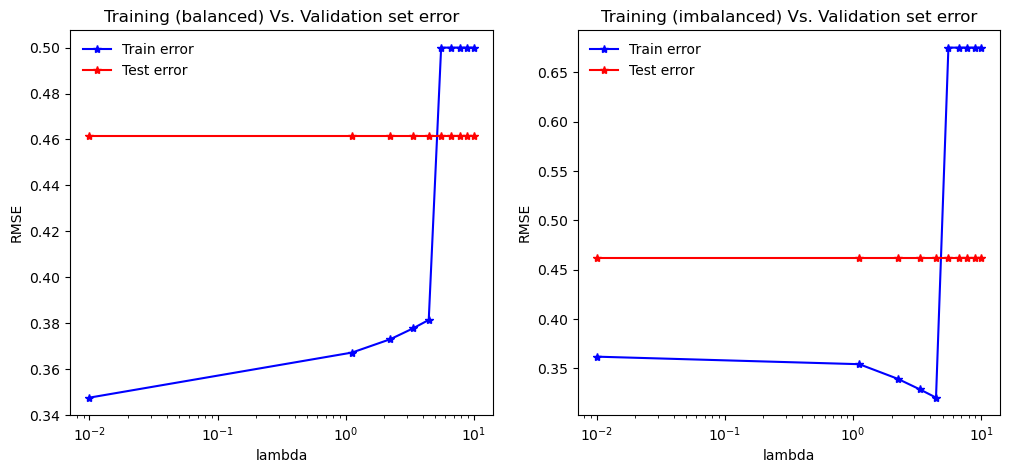

In [57]:
# Training (balanced) Vs. Validation error
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

reg_lr_ws_var_lambda = [reg_lr_ws_var_lambda_and_gamma[row, opt_col].reshape(-1,1) for row in np.arange(np.shape(reg_lr_ws_var_lambda_and_gamma)[0])]
rmse_validation = reg_lr_rmse[:,opt_col]
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, reg_lr_ws_var_lambda, penalty)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, penalty, 'lambda')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, penalty, 'lambda')

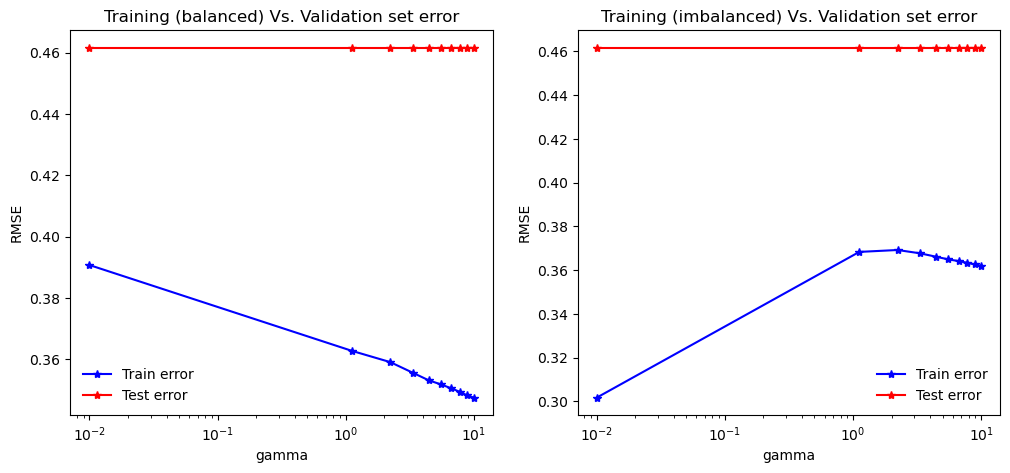

In [58]:
# Training (balanced) Vs. Validation error
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

reg_lr_ws_var_gamma = [reg_lr_ws_var_lambda_and_gamma[opt_row, col].reshape(-1,1) for col in np.arange(np.shape(reg_lr_ws_var_lambda_and_gamma)[1])]
rmse_validation = reg_lr_rmse[opt_row, :]
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, reg_lr_ws_var_gamma, learning_rate)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, penalty, 'gamma')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, penalty, 'gamma')